# **BUSINESS UNDERSTANDING**


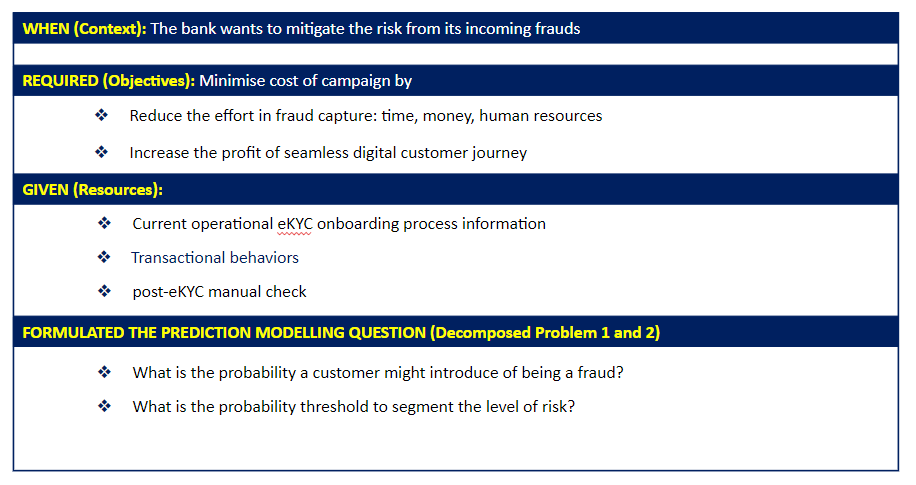

# **DATA UNDERSTANDING**

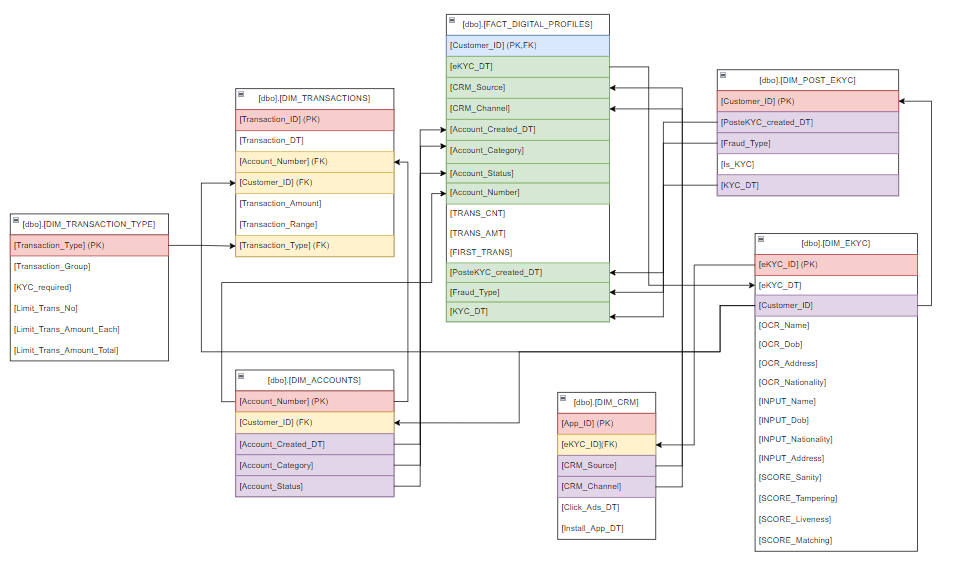

# **DATA PREPARATION**

**Feature Selection**

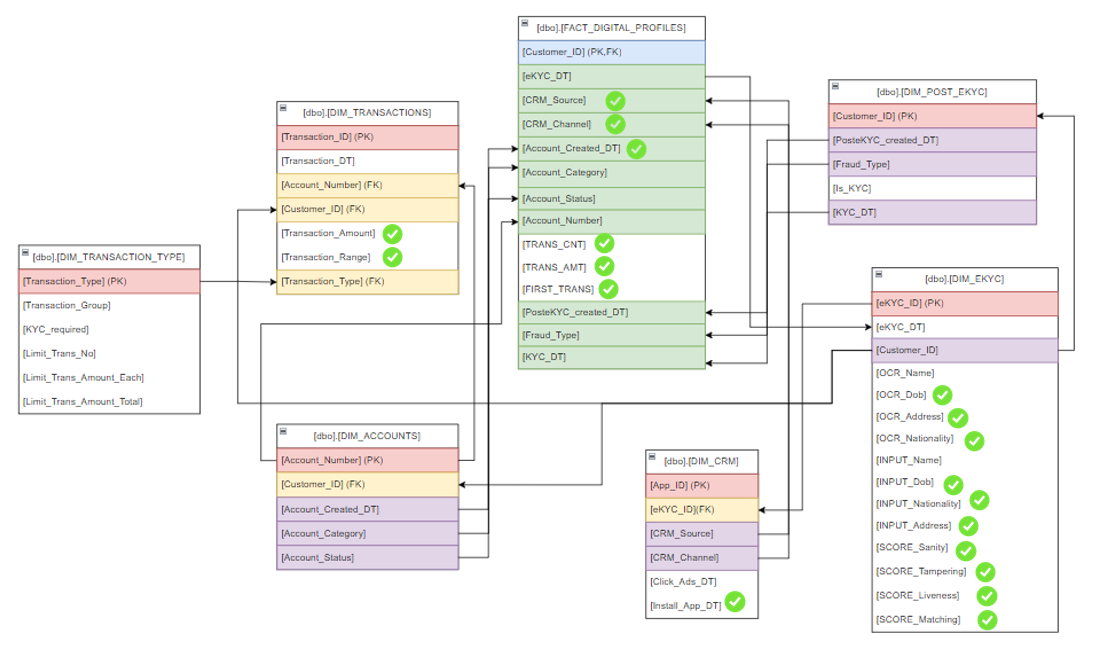

**Modelling Data Preparation**

## **Feature Engineering**

In [3]:
!pip install pyodbc
!pip install sqlserverport
!sudo apt-get install unixodbc-dev
!pip install pyodbc
!pip install chart_studio

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add /etc/apt/trusted.gpg
curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo apt install --fix-broken
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0/usr/bin/bash: line 1: apt-key: command not found
100   983  100   983    0     0   1875      0 --:--:-- --:--:-- --:--:--  1883
curl: Failed writing body
/usr/bin/bash: line 2: /etc/apt/sources.list.d/mssql-release.list: No such file or directory
/usr/bin/bash: line 3: sudo: command not found
/usr/bin/bash: line 4: sudo: command not found
/usr/bin/bash: line 5: sudo: command not found


CalledProcessError: Command 'b'curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add /etc/apt/trusted.gpg\ncurl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list\nsudo apt-get update\nsudo apt install --fix-broken\nsudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17\n'' returned non-zero exit status 127.

In [2]:
import pyodbc
import pandas as pd
import sqlserverport
import urllib
import sqlalchemy as sa

### **Loading Dataset**

#### With pyodbc

In [3]:
import pyodbc
import pandas as pd

In [4]:
#SERVER = 'DESKTOP-H49K40G\MSSQLSERVER1'
SERVER = 'DESKTOP-NF3AU5K'
DATABASE = 'DWH'

In [5]:
connectionString ='Driver={ODBC Driver 17 for SQL Server};'+f'Server={SERVER};'+ f'Database={DATABASE};'+'Trusted_Connection=yes;'

In [6]:
connectionString

'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-NF3AU5K;Database=DWH;Trusted_Connection=yes;'

In [7]:
conn = pyodbc.connect(connectionString)

#### With sqlalchemy as sa

In [10]:
# Engine
engine = sa.create_engine(f'mssql+pyodbc://{SERVER}/{DATABASE}?driver=SQL Server?Trusted_Connection=yes')

In [11]:
# establishing the connection to the databse using engine as an interface
conn = engine.connect()
# printing names of the tables present in the database
print(engine.table_names())

InterfaceError: (pyodbc.InterfaceError) ('IM002', '[IM002] [Microsoft][ODBC Driver Manager] Data source name not found and no default driver specified (0) (SQLDriverConnect)')
(Background on this error at: https://sqlalche.me/e/20/rvf5)

#### Get Dataframe

In [12]:
query_scripts = """
WITH N AS
(
	SELECT F.[CRM_Channel]
		  ,F.[Customer_ID]
		  ,C.[Install_App_DT]
		  ,F.[eKYC_DT]
		  ,[Account_Created_DT]
		  ,[FIRST_TRANS]
		  ,[TRANS_CNT]
		  ,T.[Transaction_Range] [First_Transaction_Range]
		  ,E.[OCR_Nationality]
		  ,DATEDIFF(YEAR, E.[OCR_Dob], SYSDATETIME()) [AGE]
		  ,E.[SCORE_Liveness]
		  ,E.[SCORE_Matching]
		  ,E.[SCORE_Sanity]
		  ,E.[SCORE_Tampering]
		  ,[FRAUD_TYPE]
	  --
	  FROM [dbo].[FACT_DIGITAL_PROFILES] F
	 LEFT JOIN DIM_eKYC E ON E.CUSTOMER_ID = F.CUSTOMER_ID
	 LEFT JOIN DIM_CRM C ON C.eKYC_ID = E.eKYC_ID
--
	  --FROM [DWH].[dbo].[FACT_DIGITAL_PROFILES] F
	  --LEFT JOIN [DWH].[dbo].[DIM_CRM] C ON C.[App_ID] =  F.[App_ID]
	  --LEFT JOIN  [DWH].[dbo].[DIM_EKYC] E ON E.[eKYC_ID] = C.[eKYC_ID]
	  LEFT JOIN  (SELECT [Customer_ID], [Transaction_Range]
						, ROW_NUMBER() OVER (PARTITION BY [Customer_ID] ORDER BY [Transaction_DT]) ROW_
				   FROM [DWH].[dbo].[DIM_TRANSACTION]) T ON ROW_ = 1 AND T.[Customer_ID] = F.[Customer_ID]
	 -- LEFT JOIN [BusinessCase].[dbo].[Region] R ON R.[Province_Name] = E.[OCR_Address]
 )
SELECT  [Customer_ID], [CRM_Channel]
		, DATEDIFF(DAY,[Install_App_DT], [eKYC_DT]) DT_TO_EKYC
		, DATEDIFF(DAY,[eKYC_DT], [Account_Created_DT]) DT_TO_CREATE_ACC
		, DATEDIFF(DAY,[Account_Created_DT], [FIRST_TRANS]) DT_TO_FT
		, [TRANS_CNT]
		, [First_Transaction_Range]
		, IIF([OCR_Nationality]<>'VIETNAMESE','FOREIGNER',[OCR_Nationality]) [Nationality]
		, IIF(AGE < 22, '21-', IIF(AGE<26, '22-25', IIF(AGE<30, '26-29', IIF(AGE<34, '30-33','34+')))) AGE_GROUP_range
		, [SCORE_Liveness]
		, [SCORE_Matching]
		, [SCORE_Sanity]
		, [SCORE_Tampering]
		, IIF([FRAUD_TYPE]<>'CHECKED' OR  [FRAUD_TYPE] IS NULL, 'NORMAL', 'FRAUD') [LABEL]
FROM N;
"""

In [13]:
SQL_Query = pd.read_sql_query(query_scripts, conn)
data = pd.DataFrame(SQL_Query)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29780\3457631025.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SQL_Query = pd.read_sql_query(query_scripts, conn)


In [21]:
data

,Customer_ID,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,114513,Digital Direct Sale,18,69.0,48.0,1.0,HIGH,VIETNAMESE,34+,0.85,0.93,1.00,0.92,FRAUD
1,114639,RB,8,0.0,11.0,1.0,HIGH,VIETNAMESE,30-33,0.90,0.98,0.98,0.93,NORMAL
2,114689,Partnership,103,7.0,0.0,1.0,MEDIUM HIGH,VIETNAMESE,22-25,0.98,0.97,0.97,0.93,NORMAL
3,114844,Partnership,11,0.0,9.0,1.0,HIGH,VIETNAMESE,22-25,0.97,0.93,0.98,0.99,NORMAL
4,114910,RB,18,6.0,2.0,2.0,HIGH,VIETNAMESE,21-,0.93,0.94,0.93,0.96,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,747036,Telesale,17,51.0,NaN,NaN,None,VIETNAMESE,22-25,0.90,0.97,0.93,0.96,NORMAL
47112,664501,Telesale,2,NaN,NaN,NaN,None,VIETNAMESE,21-,0.86,0.91,0.94,0.95,NORMAL
47113,687964,Digital Direct Sale,70,61.0,NaN,NaN,None,VIETNAMESE,30-33,0.95,0.88,0.89,1.00,NORMAL
47114,195782,Ecosystem,42,62.0,NaN,NaN,None,VIETNAMESE,30-33,0.87,0.97,0.96,0.87,NORMAL


In [14]:
# Backup
df_org = pd.read_csv('D:\Data science\khóa NC banking\Case 4\case 4 part 2 data science\data_science.csv')

In [23]:
df_org

,Customer_ID,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,100071,RB,224,2,0,1,4 - HIGH,VIETNAMESE,-21,0.66,0.24,0.38,0.29,FRAUD
1,100107,Partnership,5,1,3,1,4 - HIGH,VIETNAMESE,30-33,0.97,0.94,0.94,0.86,NORMAL
2,100208,Digital Direct Sale,3,14,12,1,4 - HIGH,VIETNAMESE,26-29,0.94,0.87,0.90,0.88,FRAUD
3,100331,Telesale,7,4,5,1,3 - MEDIUM HIGH,VIETNAMESE,30-33,1.00,0.93,0.91,0.91,NORMAL
4,100406,Ecosystem,29,77,30,1,4 - HIGH,VIETNAMESE,30-33,0.91,0.87,0.96,0.97,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,259518,Digital Direct Sale,5,2,1000,0,0 - NO TRANS,VIETNAMESE,30-33,0.93,0.89,0.87,0.99,FRAUD
47112,934804,Telesale,65,1000,1000,0,0 - NO TRANS,VIETNAMESE,26-29,0.96,0.91,0.99,0.96,NORMAL
47113,768662,Partnership,109,143,1000,0,0 - NO TRANS,VIETNAMESE,-21,0.90,0.91,0.90,0.92,NORMAL
47114,596361,Ecosystem,46,1000,1000,0,0 - NO TRANS,VIETNAMESE,-21,0.88,0.91,0.87,0.97,NORMAL


In [15]:
df = df_org.iloc[:,1:]

In [22]:
df

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,RB,224,2,0,1,4 - HIGH,VIETNAMESE,-21,0.66,0.24,0.38,0.29,FRAUD
1,Partnership,5,1,3,1,4 - HIGH,VIETNAMESE,30-33,0.97,0.94,0.94,0.86,NORMAL
2,Digital Direct Sale,3,14,12,1,4 - HIGH,VIETNAMESE,26-29,0.94,0.87,0.90,0.88,FRAUD
3,Telesale,7,4,5,1,3 - MEDIUM HIGH,VIETNAMESE,30-33,1.00,0.93,0.91,0.91,NORMAL
4,Ecosystem,29,77,30,1,4 - HIGH,VIETNAMESE,30-33,0.91,0.87,0.96,0.97,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,Digital Direct Sale,5,2,1000,0,0 - NO TRANS,VIETNAMESE,30-33,0.93,0.89,0.87,0.99,FRAUD
47112,Telesale,65,1000,1000,0,0 - NO TRANS,VIETNAMESE,26-29,0.96,0.91,0.99,0.96,NORMAL
47113,Partnership,109,143,1000,0,0 - NO TRANS,VIETNAMESE,-21,0.90,0.91,0.90,0.92,NORMAL
47114,Ecosystem,46,1000,1000,0,0 - NO TRANS,VIETNAMESE,-21,0.88,0.91,0.87,0.97,NORMAL


In [17]:
# Columns
columns = df.columns
columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Nationality',
       'AGE_GROUP_range', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity',
       'SCORE_Tampering', 'LABEL'],
      dtype='object')

In [18]:
# Target column
target_column = ['LABEL']
# Train columns
train_columns = columns.difference(target_column)
# Num vs Cat
num_columns = ['DT_TO_EKYC','DT_TO_CREATE_ACC', 'DT_TO_FT','TRANS_CNT', 'SCORE_Liveness', 'SCORE_Matching','SCORE_Sanity','SCORE_Tampering']
cat_columns = (columns.difference(num_columns))

In [19]:
print('Numerics:', num_columns)
print('Categorical:', cat_columns)

Numerics: ['DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT', 'TRANS_CNT', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering']
Categorical: Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range', 'LABEL',
       'Nationality'],
      dtype='object')


In [20]:
for i in cat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
AGE_GROUP_range
26-29    0.25
30-33    0.24
22-25    0.24
-21      0.22
34+      0.05
Name: proportion, dtype: float64
--------- Value report on column: CRM_Channel -----------
CRM_Channel
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: proportion, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
First_Transaction_Range
0 - NO TRANS       0.74
4 - HIGH           0.19
3 - MEDIUM HIGH    0.06
2 - MEDIUM LOW     0.01
1 - LOW            0.00
Name: proportion, dtype: float64
--------- Value report on column: LABEL -----------
LABEL
NORMAL    0.92
FRAUD     0.08
Name: proportion, dtype: float64
--------- Value report on column: Nationality -----------
Nationality
VIETNAMESE    0.98
FOREIGNER     0.02
Name: proportion, dtype: float64


### Categorical encoder

In [15]:
# df.replace({'CURRENT_OUTCOME':{'yes':1,'no':0}})

#### Binary columns

In [16]:
# Binary columns
bin_columns = ['Nationality','LABEL']
df[bin_columns].head(5)

,Nationality,LABEL
0,VIETNAMESE,FRAUD
1,VIETNAMESE,NORMAL
2,VIETNAMESE,FRAUD
3,VIETNAMESE,NORMAL
4,VIETNAMESE,NORMAL


In [17]:
replace_dict = {'Nationality': {'FOREIGNER':1,'VIETNAMESE':0}
                ,'LABEL': {'FRAUD':1,'NORMAL':0}}

In [18]:
for i in bin_columns:
  df = df.replace(replace_dict[i])

In [19]:
df = df.rename(columns={"Nationality": "Is_foreign", "LABEL": "Is_fraud"})

In [20]:
df.head(5)

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Is_foreign,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,Is_fraud
0,RB,224,2,0,1,4 - HIGH,0,-21,0.66,0.24,0.38,0.29,1
1,Partnership,5,1,3,1,4 - HIGH,0,30-33,0.97,0.94,0.94,0.86,0
2,Digital Direct Sale,3,14,12,1,4 - HIGH,0,26-29,0.94,0.87,0.90,0.88,1
3,Telesale,7,4,5,1,3 - MEDIUM HIGH,0,30-33,1.00,0.93,0.91,0.91,0
4,Ecosystem,29,77,30,1,4 - HIGH,0,30-33,0.91,0.87,0.96,0.97,0


#### Other categorical columns

In [21]:
# Other cat_columns
ocat_columns = cat_columns.difference(bin_columns)
df[ocat_columns].head(5)


,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,-21,RB,4 - HIGH
1,30-33,Partnership,4 - HIGH
2,26-29,Digital Direct Sale,4 - HIGH
3,30-33,Telesale,3 - MEDIUM HIGH
4,30-33,Ecosystem,4 - HIGH


In [22]:
ocat_columns

Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range'], dtype='object')

In [23]:
for i in ocat_columns:
  if i != 'CRM_Channel':
    df[i] = df[i].astype('category').cat.codes

In [24]:
df[ocat_columns].head(5)

,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,0,RB,4
1,3,Partnership,4
2,2,Digital Direct Sale,4
3,3,Telesale,3
4,3,Ecosystem,4


In [25]:
for i in ocat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
AGE_GROUP_range
2    0.25
3    0.24
1    0.24
0    0.22
4    0.05
Name: proportion, dtype: float64
--------- Value report on column: CRM_Channel -----------
CRM_Channel
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: proportion, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
First_Transaction_Range
0    0.74
4    0.19
3    0.06
2    0.01
1    0.00
Name: proportion, dtype: float64


=> Rule:


1.   AGE_GROUP_range:
*   21- - 0
*   22-25 - 1
*   26-29  - 2
*   30-34 - 3
*   34+ - 4

2.   First_Transaction_Range
*   No Trans - 0
*   LOW - 1
*   MEDIUM LOW - 2
*   MEDIUM HIGH - 3
*   HIGH - 4

#### **One-hot encoding**

3.   CRM_Channel
*   Digital Direct Sale
*   Ecosystem
*   Partnership
*   RB
*   Telesale

In [27]:
one_hot = pd.get_dummies(df['CRM_Channel'])

In [28]:
one_hot

,Digital Direct Sale,Ecosystem,Partnership,RB,Telesale
0,False,False,False,True,False
1,False,False,True,False,False
2,True,False,False,False,False
3,False,False,False,False,True
4,False,True,False,False,False
...,...,...,...,...,...
47111,True,False,False,False,False
47112,False,False,False,False,True
47113,False,False,True,False,False
47114,False,True,False,False,False


In [29]:
df_list = [df, one_hot]
df_con = pd.concat(df_list, axis=1)

In [30]:
df_con.columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Is_foreign', 'AGE_GROUP_range',
       'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering',
       'Is_fraud', 'Digital Direct Sale', 'Ecosystem', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [31]:
df_con[num_columns].head(5)

,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering
0,224,2,0,1,0.66,0.24,0.38,0.29
1,5,1,3,1,0.97,0.94,0.94,0.86
2,3,14,12,1,0.94,0.87,0.90,0.88
3,7,4,5,1,1.00,0.93,0.91,0.91
4,29,77,30,1,0.91,0.87,0.96,0.97


### Distribution on Target

In [32]:
columns = df_con.columns
# Target column
target_column = ['Is_fraud']
# Train columns
train_columns = columns.difference(target_column+['CRM_Channel'])

In [33]:
X = df_con[train_columns]
y = df_con[target_column]

In [34]:
# Data size
df_con.shape[0]

47116

<Axes: ylabel='target_column'>

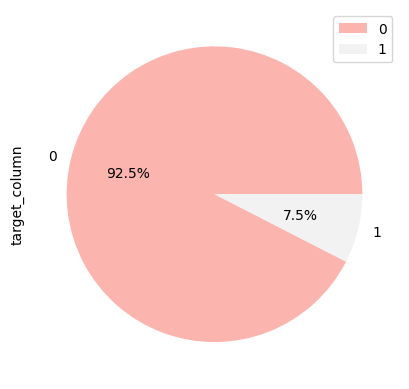

In [36]:
import matplotlib.pyplot as plt 
y.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1') #https://matplotlib.org/stable/tutorials/colors/colormaps.html#

The value of current outcome is imbalance and as we have only 47,116 records -> not much for downsampling -> we upweighting instead

In [37]:
X.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,0,2,224,0,False,False,4,0,False,True,0.66,0.24,0.38,0.29,1,False
1,3,1,5,3,False,False,4,0,True,False,0.97,0.94,0.94,0.86,1,False
2,2,14,3,12,True,False,4,0,False,False,0.94,0.87,0.90,0.88,1,False
3,3,4,7,5,False,False,3,0,False,False,1.00,0.93,0.91,0.91,1,True
4,3,77,29,30,False,True,4,0,False,False,0.91,0.87,0.96,0.97,1,False


In [38]:
y.head(5)

,Is_fraud
0,1
1,0
2,1
3,0
4,0


#### **Upsampling with SMOTE**

In [39]:
#from imblearn import under_sampling, over_sampling
import sklearn
print(sklearn.__version__)

1.2.2


In [40]:
from imblearn.over_sampling import SMOTE

su = SMOTE(random_state=42)
X_su, y_su = su.fit_resample(X, y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

<Axes: ylabel='target_column'>

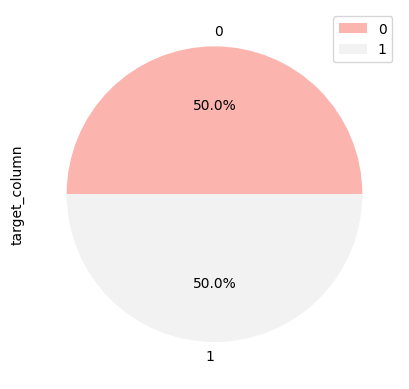

In [41]:
y_su.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1') #https://matplotlib.org/stable/tutorials/colors/colormaps.html#

### Outlier Handler

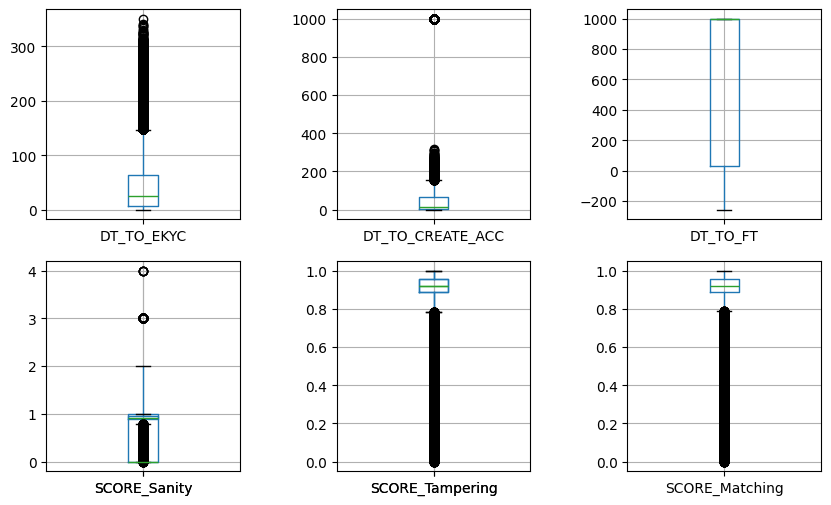

In [42]:
import matplotlib.pyplot as plt

# df[num_columns].plot(
#     kind='box',
#     subplots=True,
#     sharey=False,
#     figsize=(10, 6)
# )

# 4 subplots in one row
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(len(num_columns)):
    if i > 2:
      j=1
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i%3])
    else:
      j=0
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i])

# draw boxplots - for one column in each subplot
# data_df.boxplot('age', ax=ax[0])
# data_df.boxplot('station_distance', ax=ax[1])
# data_df.boxplot('stores_count', ax=ax[2])
# data_df.boxplot('unit_price', ax=ax[3])

plt.subplots_adjust(wspace=0.5)

plt.show()

In [43]:
X_su.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,0,2,224,0,False,False,4,0,False,True,0.66,0.24,0.38,0.29,1,False
1,3,1,5,3,False,False,4,0,True,False,0.97,0.94,0.94,0.86,1,False
2,2,14,3,12,True,False,4,0,False,False,0.94,0.87,0.90,0.88,1,False
3,3,4,7,5,False,False,3,0,False,False,1.00,0.93,0.91,0.91,1,True
4,3,77,29,30,False,True,4,0,False,False,0.91,0.87,0.96,0.97,1,False


In [44]:
import numpy as np

''' Detection '''
def outlier_handler(df,col):
    # IQR
    # Calculate the upper and lower limits
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
    # Create arrays of Boolean values indicating the outlier rows
    # upper_array = np.where(X_su[col]>=upper)[0]
    # lower_array = np.where(X_su[col]<=lower)[0]

    # Removing the outliers
    # X_su.drop(index=upper_array, inplace=True)
    # X_su.drop(index=lower_array, inplace=True)




In [45]:
for i in num_columns:
    X_su = outlier_handler(X_su,i)

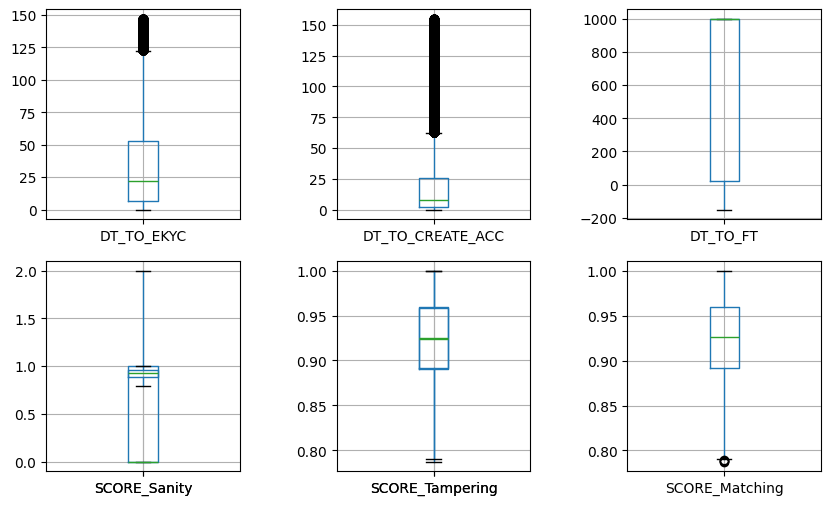

In [46]:
import matplotlib.pyplot as plt

# df[num_columns].plot(
#     kind='box',
#     subplots=True,
#     sharey=False,
#     figsize=(10, 6)
# )

# 4 subplots in one row
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for i in range(len(num_columns)):
    if i > 2:
      j=1
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i%3])
    else:
      j=0
      X_su[num_columns].boxplot(num_columns[i], ax=ax[j,i])

# draw boxplots - for one column in each subplot
# data_df.boxplot('age', ax=ax[0])
# data_df.boxplot('station_distance', ax=ax[1])
# data_df.boxplot('stores_count', ax=ax[2])
# data_df.boxplot('unit_price', ax=ax[3])

plt.subplots_adjust(wspace=0.5)

plt.show()

In [47]:
# Print the new shape of the DataFrame
print("New Shape: ", X_su.shape)

New Shape:  (62911, 16)


In [48]:
X_su.shape

(62911, 16)

In [49]:
y_su.shape

(87126, 1)

In [50]:
X_su.index

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       87116, 87117, 87118, 87119, 87120, 87121, 87122, 87123, 87124, 87125],
      dtype='int64', length=62911)

In [51]:
# Restruct target
new_df = X_su.copy()
new_df['target'] = y_su.loc[X_su.index]

In [52]:
new_cat_columns = X_su.columns.difference(num_columns)

In [53]:
new_cat_columns

Index(['AGE_GROUP_range', 'Digital Direct Sale', 'Ecosystem',
       'First_Transaction_Range', 'Is_foreign', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [54]:
for i in new_cat_columns:
  if i != 'CURRENT_OUTCOME':
    print('--------- Value report on column:',i,'-----------')
    report = X_su[i].value_counts(normalize=True,ascending=False).round(2)
    print(report)

--------- Value report on column: AGE_GROUP_range -----------
AGE_GROUP_range
1    0.27
2    0.26
0    0.24
3    0.20
4    0.02
Name: proportion, dtype: float64
--------- Value report on column: Digital Direct Sale -----------
Digital Direct Sale
False    0.73
True     0.27
Name: proportion, dtype: float64
--------- Value report on column: Ecosystem -----------
Ecosystem
False    0.72
True     0.28
Name: proportion, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
First_Transaction_Range
0    0.63
4    0.23
3    0.13
2    0.01
1    0.00
Name: proportion, dtype: float64
--------- Value report on column: Is_foreign -----------
Is_foreign
0    0.99
1    0.01
Name: proportion, dtype: float64
--------- Value report on column: Partnership -----------
Partnership
False    0.73
True     0.27
Name: proportion, dtype: float64
--------- Value report on column: RB -----------
RB
False    0.73
True     0.27
Name: proportion, dtype: float64
--------- Value report 

### **Data Selection**

In [55]:
X_su.corr().round(2)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
AGE_GROUP_range,1.00,-0.02,-0.02,0.01,-0.03,-0.04,-0.01,0.01,-0.04,-0.01,-0.01,0.01,-0.01,0.00,-0.01,-0.00
DT_TO_CREATE_ACC,-0.02,1.00,0.19,-0.04,-0.00,0.04,0.04,0.01,0.00,0.03,0.02,-0.01,-0.00,0.01,0.04,0.02
DT_TO_EKYC,-0.02,0.19,1.00,-0.01,0.00,0.03,0.01,0.01,0.06,0.02,0.01,0.02,-0.01,0.01,0.01,-0.00
DT_TO_FT,0.01,-0.04,-0.01,1.00,-0.01,-0.01,-0.98,-0.00,-0.02,-0.02,0.01,0.01,0.01,-0.00,-0.96,-0.03
Digital Direct Sale,-0.03,-0.00,0.00,-0.01,1.00,-0.19,0.01,-0.02,-0.18,-0.19,-0.00,-0.00,-0.01,0.02,0.01,-0.20
Ecosystem,-0.04,0.04,0.03,-0.01,-0.19,1.00,0.00,-0.02,-0.20,-0.20,0.01,-0.00,0.00,-0.01,-0.00,-0.19
First_Transaction_Range,-0.01,0.04,0.01,-0.98,0.01,0.00,1.00,0.00,0.02,0.01,-0.01,-0.01,-0.01,0.01,0.94,0.03
Is_foreign,0.01,0.01,0.01,-0.00,-0.02,-0.02,0.00,1.00,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,-0.02
Partnership,-0.04,0.00,0.06,-0.02,-0.18,-0.20,0.02,-0.01,1.00,-0.19,-0.00,0.01,-0.00,0.01,0.01,-0.18
RB,-0.01,0.03,0.02,-0.02,-0.19,-0.20,0.01,-0.01,-0.19,1.00,0.01,0.00,-0.01,-0.01,0.01,-0.19


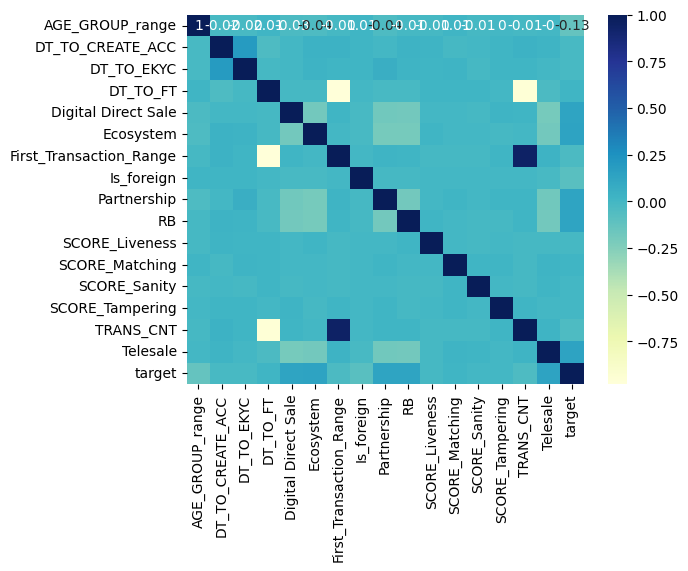

In [57]:
# import modules
import matplotlib.pyplot as mp
import seaborn as sb


# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
corr_mat = new_df.corr().round(2)

# plotting correlation heatmap
dataplot = sb.heatmap(corr_mat, cmap="YlGnBu", annot=True)

# displaying heatmap
mp.show()

In [58]:
abs(corr_mat['target']).quantile(0.5)

0.04

In [59]:
#corr_mat[abs(corr_mat['target'])>0.04]

We only take the top 50% of correlation with target
-> we remove all the columns with abs correlation less than 0.04

In [60]:
corr_mat[abs(corr_mat['target'])<=0.04]

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale,target
DT_TO_CREATE_ACC,-0.02,1.00,0.19,-0.04,-0.00,0.04,0.04,0.01,0.00,0.03,0.02,-0.01,-0.00,0.01,0.04,0.02,-0.02
DT_TO_EKYC,-0.02,0.19,1.00,-0.01,0.00,0.03,0.01,0.01,0.06,0.02,0.01,0.02,-0.01,0.01,0.01,-0.00,-0.02
DT_TO_FT,0.01,-0.04,-0.01,1.00,-0.01,-0.01,-0.98,-0.00,-0.02,-0.02,0.01,0.01,0.01,-0.00,-0.96,-0.03,0.01
First_Transaction_Range,-0.01,0.04,0.01,-0.98,0.01,0.00,1.00,0.00,0.02,0.01,-0.01,-0.01,-0.01,0.01,0.94,0.03,-0.03
SCORE_Liveness,-0.01,0.02,0.01,0.01,-0.00,0.01,-0.01,0.00,-0.00,0.01,1.00,-0.00,-0.01,0.00,-0.01,-0.01,-0.01
SCORE_Matching,0.01,-0.01,0.02,0.01,-0.00,-0.00,-0.01,0.00,0.01,0.00,-0.00,1.00,0.01,0.01,-0.01,0.02,0.01
SCORE_Sanity,-0.01,-0.00,-0.01,0.01,-0.01,0.00,-0.01,-0.00,-0.00,-0.01,-0.01,0.01,1.00,0.00,-0.01,0.01,-0.00
SCORE_Tampering,0.00,0.01,0.01,-0.00,0.02,-0.01,0.01,-0.00,0.01,-0.01,0.00,0.01,0.00,1.00,0.01,-0.00,0.00
TRANS_CNT,-0.01,0.04,0.01,-0.96,0.01,-0.00,0.94,0.00,0.01,0.01,-0.01,-0.01,-0.01,0.01,1.00,0.02,-0.04


In [61]:
train_df = new_df.drop(columns=['DT_TO_CREATE_ACC','DT_TO_EKYC','DT_TO_FT','First_Transaction_Range','SCORE_Liveness','SCORE_Matching','SCORE_Sanity','SCORE_Tampering','TRANS_CNT'])

In [62]:
bk_train_df = new_df.drop(columns=['DT_TO_CREATE_ACC','DT_TO_EKYC','DT_TO_FT','First_Transaction_Range','SCORE_Liveness','SCORE_Matching','SCORE_Sanity','SCORE_Tampering','TRANS_CNT'])

In [63]:
train_df

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,False,False,0,True,False,False,0
2,2,True,False,0,False,False,False,1
3,3,False,False,0,False,False,True,0
4,3,False,True,0,False,False,False,0
5,2,False,False,1,False,True,False,0
...,...,...,...,...,...,...,...,...
87121,1,False,True,0,False,True,False,1
87122,1,False,False,0,True,True,False,1
87123,2,False,True,0,False,True,False,1
87124,2,False,True,0,False,True,False,1


<Axes: >

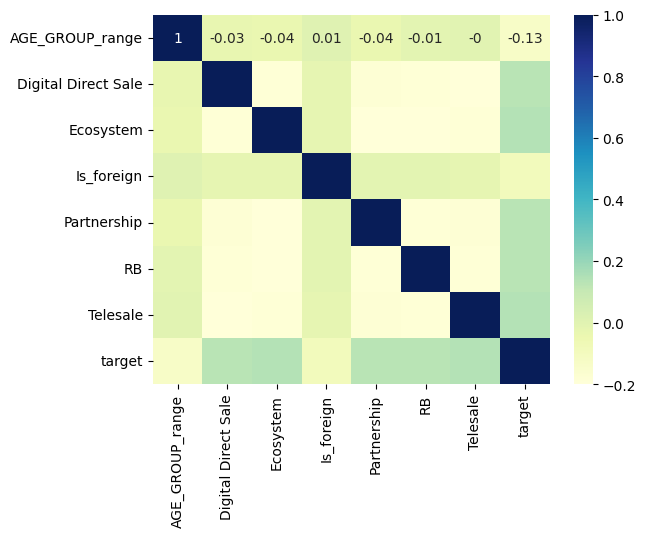

In [64]:
sb.heatmap(round(train_df.corr(),2), cmap="YlGnBu", annot=True)

In [65]:
bk_train_df.shape

(62911, 8)

In [66]:
train_df.shape

(62911, 8)

## Hold-out set

In [67]:
hold_out_df = train_df.sample(12500)

In [68]:
hold_out_df.shape

(12500, 8)

In [69]:
removed_df = train_df.index.isin(hold_out_df.index)

In [70]:
train_df = train_df[~removed_df]

In [71]:
train_df.shape

(50411, 8)

# DATA MODEL

In [72]:
import sklearn

In [73]:
train_df.shape

(50411, 8)

In [74]:
train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,False,False,0,True,False,False,0
2,2,True,False,0,False,False,False,1
3,3,False,False,0,False,False,True,0
4,3,False,True,0,False,False,False,0
5,2,False,False,1,False,True,False,0


In [75]:
X = train_df.iloc[:,:7]
y = train_df.iloc[:,-1]

In [76]:
X.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
1,3,False,False,0,True,False,False
2,2,True,False,0,False,False,False
3,3,False,False,0,False,False,True
4,3,False,True,0,False,False,False
5,2,False,False,1,False,True,False


In [77]:
y.head(5)

1    0
2    1
3    0
4    0
5    0
Name: target, dtype: int64

### Feature Scaler

In [78]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

scaled_X = scale.fit_transform(X)

print(scaled_X)

[[ 1.34567033 -0.61263412 -0.61943615 ...  1.62781979 -0.61428798
  -0.60990919]
 [ 0.46037569  1.63229563 -0.61943615 ... -0.61431861 -0.61428798
  -0.60990919]
 [ 1.34567033 -0.61263412 -0.61943615 ... -0.61431861 -0.61428798
   1.63958834]
 ...
 [ 0.46037569 -0.61263412  1.6143714  ... -0.61431861  1.62790096
  -0.60990919]
 [ 0.46037569 -0.61263412  1.6143714  ... -0.61431861  1.62790096
  -0.60990919]
 [ 1.34567033  1.63229563 -0.61943615 ...  1.62781979 -0.61428798
  -0.60990919]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [79]:
X_scaled = pd.DataFrame(scaled_X)
X_scaled.columns = X.columns

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_scaled, y, test_size=0.25, random_state=18)


In [81]:
X_train.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
34680,-0.424919,1.632296,-0.619436,-0.105412,-0.614319,1.627901,-0.609909
5997,-0.424919,-0.612634,1.614371,-0.105412,-0.614319,-0.614288,-0.609909
41593,1.345670,-0.612634,-0.619436,-0.105412,1.627820,-0.614288,1.639588
20222,1.345670,1.632296,-0.619436,-0.105412,-0.614319,-0.614288,-0.609909
33212,-0.424919,-0.612634,1.614371,-0.105412,-0.614319,-0.614288,-0.609909


In [82]:
y.head(5)

1    0
2    1
3    0
4    0
5    0
Name: target, dtype: int64

In [83]:
X_train.shape

(37808, 7)

In [84]:
y_train.shape

(37808,)

## Model comprehension

In [85]:
#Import all the learning algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [86]:
#Import some utilities of sklearn to compare algorithms
from sklearn import  model_selection
from sklearn.metrics import classification_report #Reporting metric
from sklearn.metrics import confusion_matrix #Confusion_matrix Reporting
from sklearn.metrics import accuracy_score #Accuracy calculating

In [87]:
# Prepare the configuration to run the test
results=[]
names=[]

In [88]:
# Prepare an array with all the algorithms
models = []
models.append(('LR',LogisticRegression()))
models.append(('CARD',DecisionTreeClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('NB',GaussianNB()))
models.append(('RFC',RandomForestClassifier()))

In [89]:
#Evaluate each model in turn
for name,model in models:
    kfold=model_selection.KFold(n_splits=10)
    cv_results=model_selection.cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg="%s:%f(%f)"%(name,cv_results.mean(),cv_results.std())
    print(msg)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

LR:0.615222(0.006290)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

CARD:0.615222(0.006290)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

KNN:0.758601(0.034937)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

LDA:0.615222(0.006290)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

NB:0.997180(0.001250)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

RFC:0.615222(0.006290)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Model Evaluation

### **Boxplot algorithm comparison**

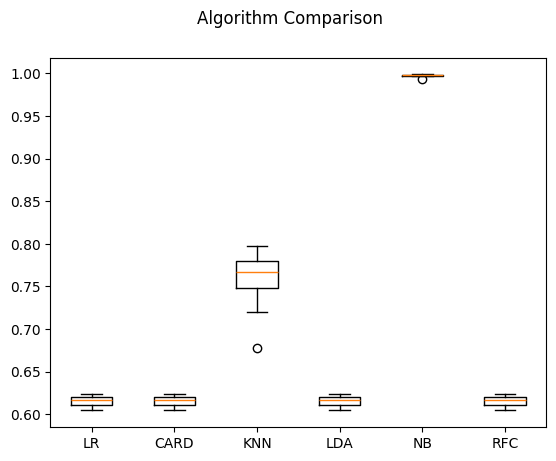

In [90]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

=> NB: Good Recall

### **ROC CURVE FOR COMPARISON**

In [91]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_scaled,y)
y_score_lr = cross_val_predict(lr, X_scaled, y, method='decision_function',cv=10)
fpr, tpr, threshold = roc_curve(y,y_score_lr)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
card = DecisionTreeClassifier()
card.fit(X_scaled,y)
y_score_card = cross_val_predict(card, X_scaled, y, method='predict_proba',cv=10)
fpr_card, tpr_card, threshold_card = roc_curve(y, y_score_card[:, 1])

# K Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_scaled,y)
knc_results = cross_val_score(knc,X_scaled,y,scoring='accuracy')
y_score_knn = cross_val_predict(knc,X_scaled,y,method='predict_proba',cv=10)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y,y_score_knn[:,1])

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled,y)
lda_results = cross_val_score(lda,X_scaled,y,scoring='accuracy')
y_score_lda = cross_val_predict(lda,X_scaled,y,method='predict_proba',cv=10)
fpr_lda, tpr_lda, threshold_lda = roc_curve(y,y_score_lda[:,1])

# GaussianNB
from sklearn.naive_bayes import GaussianNB

gnbc = GaussianNB()
gnbc.fit(X_scaled,y)
gnbc_results = cross_val_score(gnbc,X_scaled,y,scoring='accuracy')
y_score_gnb = cross_val_predict(gnbc,X_scaled,y,method='predict_proba',cv=10)
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y,y_score_gnb[:,1])

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_scaled,y)
rfc_results = cross_val_score(rfc,X_scaled,y,scoring='accuracy')
y_score_rfc = cross_val_predict(rfc,X_scaled,y,method='predict_proba',cv=10)
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y,y_score_rfc[:,1])



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

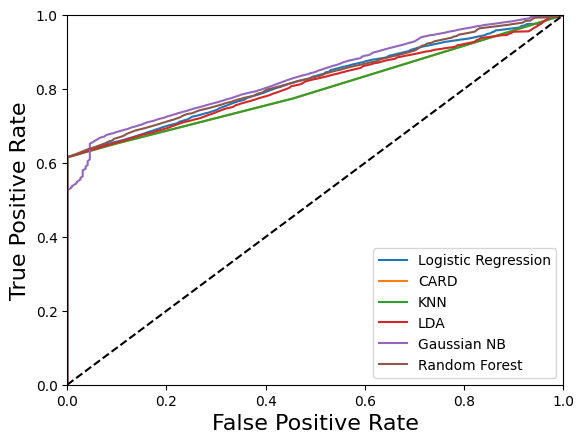

<Figure size 1000x600 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

In [92]:
# ROC Curve for the models above
plt.plot(fpr,tpr,label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn,label='CARD')
plt.plot(fpr_knn, tpr_knn,label='KNN')
plt.plot(fpr_lda, tpr_lda,label='LDA')
plt.plot(fpr_gnb, tpr_gnb,label='Gaussian NB')
plt.plot(fpr_rfc, tpr_rfc,label='Random Forest')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(10, 6))
plt.show()
plt.show

=> RF: Good Precision

**Voting Ensemble Method**

We use soft voting ensemble method to predict the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

We fit the model to the third dataset, smallest and representative

In [93]:
from sklearn.ensemble import VotingClassifier

In [94]:
Vote_Ensemble = VotingClassifier(estimators=[('nb', gnbc), ('rf', rfc)], voting='soft')

In [95]:
Vote_Ensemble.fit(X_scaled,y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [96]:
Vote_Ensemble

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [104]:
# Save model
import pickle
# save the model to disk   D:\Data science\khóa NC banking\Case 4
filename = 'D:\Data science\khóa NC banking\Case 4\model.pkl'
pickle.dump(Vote_Ensemble, open(filename, 'wb'))

# DATA EVALUATION & THRESHOLD JUSTIFICATION


In [105]:
loaded_model = pickle.load(open(filename, 'rb'))

**Loading hold out set**

In [106]:
hold_out_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
15979,2,False,True,0,False,False,False,0
31761,2,False,False,0,False,True,False,0
59400,3,False,False,0,False,False,True,1
79562,2,False,False,0,False,True,False,1
8458,3,True,False,0,False,False,False,0


In [107]:
X_holdout = hold_out_df.iloc[:,0:7]
y_holdout = hold_out_df.iloc[:,-1]

In [108]:
scaled_X_test = scale.fit_transform(X_holdout)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [109]:
X_test_scaled = pd.DataFrame(scaled_X_test)
X_test_scaled.columns = X_scaled.columns

In [110]:
X_test_scaled.head(5)


,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,0.460961,-0.622744,1.603886,-0.106043,-0.608781,-0.609275,-0.612238
1,0.460961,-0.622744,-0.623486,-0.106043,-0.608781,1.641296,-0.612238
2,1.349338,-0.622744,-0.623486,-0.106043,-0.608781,-0.609275,1.633352
3,0.460961,-0.622744,-0.623486,-0.106043,-0.608781,1.641296,-0.612238
4,1.349338,1.605798,-0.623486,-0.106043,-0.608781,-0.609275,-0.612238


In [111]:
loaded_model.fit(X_test_scaled,y_holdout)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [112]:
loaded_model.predict(X_test_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [113]:
X_test_scaled.shape

(12500, 7)

In [114]:
y_holdout.shape

(12500,)

### Confusion Matrix

In [115]:
# Make predictions on the test set
y_pred = loaded_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_holdout, y_pred)
classification_report_str = classification_report(y_holdout, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.21      0.33      4887
           1       0.65      0.95      0.77      7613

    accuracy                           0.66     12500
   macro avg       0.70      0.58      0.55     12500
weighted avg       0.69      0.66      0.60     12500



### Justify the threshold

In [116]:
import matplotlib.pyplot as plt

# Assuming y_score is the result of predict_proba
# y_score should be a 2D array with shape (n_samples, n_classes)
# Let's assume we want to create a box plot for class 1
class_index = [1]
y_score = loaded_model.predict_proba(X_test_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [117]:
loaded_model.predict_proba(X_test_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

array([[0.37993983, 0.62006017],
       [0.42840154, 0.57159846],
       [0.49327132, 0.50672868],
       ...,
       [0.05995744, 0.94004256],
       [0.03901542, 0.96098458],
       [0.49813175, 0.50186825]])

In [118]:
test = X_test_scaled.copy()
test['prob'] = loaded_model.predict_proba(X_test_scaled)[:,1]
test['output'] = loaded_model.predict(X_test_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [119]:
fail = test.loc[test['output']==0,'prob']
success = test.loc[test['output']==1,'prob']

Text(0.5, 1.0, 'Box Plot Comparison')

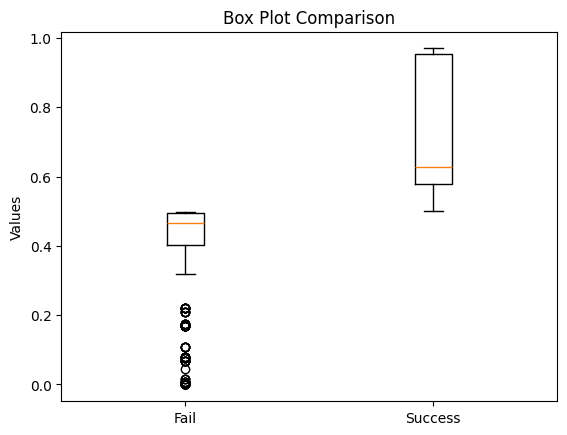

In [120]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Create the box plots
ax.boxplot([fail, success])

# Set labels and title
ax.set_xticklabels(['Fail', 'Success'])
ax.set_ylabel('Values')
ax.set_title('Box Plot Comparison')

In [121]:
success.describe()

count    11100.000000
mean         0.738942
std          0.183793
min          0.501868
25%          0.577568
50%          0.627668
75%          0.952366
max          0.969542
Name: prob, dtype: float64

**Try raising the threshold up to 0.45**

In [122]:
y_pred_threshold = np.array([1 if i >= 0.45 else 0 for i in test['prob']])

In [123]:
classification_report_str = classification_report(y_holdout, y_pred_threshold)
accuracy = accuracy_score(y_holdout, y_pred_threshold)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [124]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [125]:
# Threshold = 0.45
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.06      0.12      4887
           1       0.62      0.99      0.77      7613

    accuracy                           0.63     12500
   macro avg       0.73      0.53      0.44     12500
weighted avg       0.70      0.63      0.51     12500



In [126]:
# Threshold = 0.5

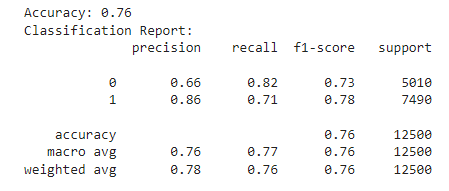

=> The accuracy drop a tiny bit (2%). However, the model become stricter in classifying a customer as normal -> lower threshold to catch fraud -> the recall for 1 and precision for 0 raise =>  => More accurate in catch 'sophisticated fraud' => In return, we lose the opportunity to save cost as the precision/right level of prediction drop

In [127]:
y_pred_threshold_1 = np.array([1 if i >= 0.4 else 0 for i in test['prob']])

In [128]:
accuracy_1 = accuracy_score(y_holdout, y_pred_threshold_1)
print(f"Accuracy: {accuracy_1:.2f}")
print("Classification Report:")
c1 = classification_report(y_holdout, y_pred_threshold_1)
print(c1)



Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.06      0.11      4887
           1       0.62      0.99      0.76      7613

    accuracy                           0.63     12500
   macro avg       0.74      0.53      0.44     12500
weighted avg       0.71      0.63      0.51     12500



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

### Optimize threshold

=> Remember to optimize the f1-score if you want to balance precision and recall. Also, know what you prioritize in precision or recall to make the trade-offs

In [129]:
y_score.shape

(12500, 2)

In [130]:
y_score_positive = y_score[:, 1]

In [131]:
y_score_positive.shape

(12500,)

In [132]:
print("y_test shape:", y_test.shape)
print("y_score_positive shape:", y_score_positive.shape)

y_test shape: (12603,)
y_score_positive shape: (12500,)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

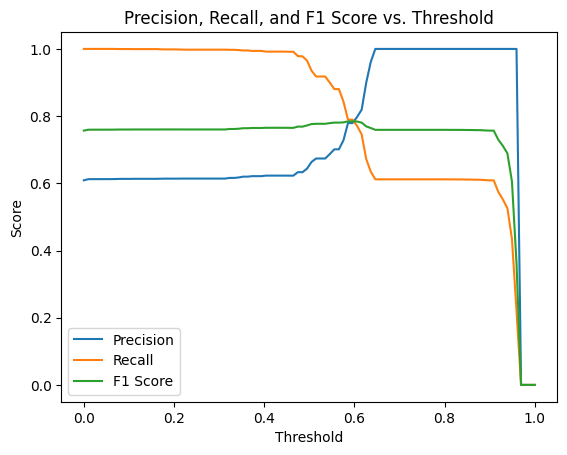

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test contains the true labels and y_score_positive contains the predicted probabilities for the positive class

# Define a range of thresholds
thresholds = np.linspace(0, 1, num=100)

# Calculate precision, recall, and F1 score for each threshold
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_score_positive >= threshold).astype(int)
    precisions.append(precision_score(y_holdout, y_pred))
    recalls.append(recall_score(y_holdout, y_pred))
    f1_scores.append(f1_score(y_holdout, y_pred))

# Plot precision, recall, and F1 score against thresholds
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

# Set labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()

# Show the plot
plt.show()

# MODEL OUTPUT

In [134]:
bk_train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,False,False,0,True,False,False,0
2,2,True,False,0,False,False,False,1
3,3,False,False,0,False,False,True,0
4,3,False,True,0,False,False,False,0
5,2,False,False,1,False,True,False,0


In [135]:
X_bk = bk_train_df.iloc[:,0:7]
y_bk = bk_train_df.iloc[:,-1]

In [136]:
scaled_X_bk = scale.fit_transform(X_bk)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [137]:
loaded_model.fit(scaled_X_bk,y_bk)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [138]:
X_bk_scaled = pd.DataFrame(scaled_X_bk)
X_bk_scaled.columns = X_scaled.columns

In [139]:
X_bk_scaled.head(5)


,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,1.346396,-0.614641,-0.620241,-0.105538,1.630742,-0.613292,-0.610372
1,0.460491,1.626965,-0.620241,-0.105538,-0.613218,-0.613292,-0.610372
2,1.346396,-0.614641,-0.620241,-0.105538,-0.613218,-0.613292,1.638346
3,1.346396,-0.614641,1.612278,-0.105538,-0.613218,-0.613292,-0.610372
4,0.460491,-0.614641,-0.620241,9.475266,-0.613218,1.630546,-0.610372


In [140]:
loaded_model.predict(X_bk_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\skle

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [141]:
df_fin = X_bk_scaled.copy()

In [142]:
df_fin['y_actual'] = y_bk
df_fin['prob'] = loaded_model.predict_proba(X_bk_scaled)[:,1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\skle

In [143]:
df_fin.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,1.346396,-0.614641,-0.620241,-0.105538,1.630742,-0.613292,-0.610372,NaN,0.466792
1,0.460491,1.626965,-0.620241,-0.105538,-0.613218,-0.613292,-0.610372,0.0,0.548880
2,1.346396,-0.614641,-0.620241,-0.105538,-0.613218,-0.613292,1.638346,1.0,0.515832
3,1.346396,-0.614641,1.612278,-0.105538,-0.613218,-0.613292,-0.610372,0.0,0.492082
4,0.460491,-0.614641,-0.620241,9.475266,-0.613218,1.630546,-0.610372,0.0,0.143795


In [144]:
y_pred_threshold_fin = np.array([1 if i >= 0.45 else 0 for i in df_fin['prob']])

In [145]:
accuracy_fin = accuracy_score(y_bk, y_pred_threshold_fin)
print(f"Accuracy: {accuracy_fin:.2f}")
c_fin = classification_report(y_bk, y_pred_threshold_fin)
print(c_fin)

Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.85      0.07      0.13     25059
           1       0.62      0.99      0.76     37852

    accuracy                           0.62     62911
   macro avg       0.73      0.53      0.44     62911
weighted avg       0.71      0.62      0.51     62911



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [147]:
#D:\Data science\khóa NC banking\Case 4
df_fin.to_csv('D:\Data science\khóa NC banking\Case 4\output_nam.csv')

In [148]:
df_fin

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,1.346396,-0.614641,-0.620241,-0.105538,1.630742,-0.613292,-0.610372,NaN,0.466792
1,0.460491,1.626965,-0.620241,-0.105538,-0.613218,-0.613292,-0.610372,0.0,0.548880
2,1.346396,-0.614641,-0.620241,-0.105538,-0.613218,-0.613292,1.638346,1.0,0.515832
3,1.346396,-0.614641,1.612278,-0.105538,-0.613218,-0.613292,-0.610372,0.0,0.492082
4,0.460491,-0.614641,-0.620241,9.475266,-0.613218,1.630546,-0.610372,0.0,0.143795
...,...,...,...,...,...,...,...,...,...
62906,-0.425413,-0.614641,1.612278,-0.105538,-0.613218,1.630546,-0.610372,1.0,0.958974
62907,-0.425413,-0.614641,-0.620241,-0.105538,1.630742,1.630546,-0.610372,1.0,0.956968
62908,0.460491,-0.614641,1.612278,-0.105538,-0.613218,1.630546,-0.610372,1.0,0.948957
62909,0.460491,-0.614641,1.612278,-0.105538,-0.613218,1.630546,-0.610372,1.0,0.948957


In [149]:
df

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Is_foreign,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,Is_fraud
0,RB,224,2,0,1,4,0,0,0.66,0.24,0.38,0.29,1
1,Partnership,5,1,3,1,4,0,3,0.97,0.94,0.94,0.86,0
2,Digital Direct Sale,3,14,12,1,4,0,2,0.94,0.87,0.90,0.88,1
3,Telesale,7,4,5,1,3,0,3,1.00,0.93,0.91,0.91,0
4,Ecosystem,29,77,30,1,4,0,3,0.91,0.87,0.96,0.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,Digital Direct Sale,5,2,1000,0,0,0,3,0.93,0.89,0.87,0.99,1
47112,Telesale,65,1000,1000,0,0,0,2,0.96,0.91,0.99,0.96,0
47113,Partnership,109,143,1000,0,0,0,0,0.90,0.91,0.90,0.92,0
47114,Ecosystem,46,1000,1000,0,0,0,0,0.88,0.91,0.87,0.97,0


In [150]:
#df_org